## <strong>Proyecto: Concentración de PM2.5 en Pekín y su relación con otras variables meteorológicas.</strong>

Importación de librerías

In [22]:
#Librerías
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from google.colab import drive
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import calendar
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importación de datos

In [23]:
path = '/content/drive/My Drive/'
folder = 'intro_cienciadatos/dataset/'
file = 'PRSA_data_2010.1.1-2014.12.31.csv'

df_original = pd.read_csv(path + folder + file)
df = df_original.copy()

# Descripción de la base de datos

El dataset original incluye mediciones horarias de:

| Variable  | Nombre y Unidades | Rango típico | Descripción | Tipo de variable |
|-----------|-------------|------------------|---------------|------------------|
| **pm2.5** | Concentración de PM₂.₅ (µg/m³) | 0 a 500µg/m³  | Material Particulado Fino. Mide la concentración de partículas en el aire con un diámetro aerodinámico de 2.5 micrómetros o menos. | Continua, cuantitativa |
| **DEWP**  | Punto de rocío (℃) | -30 a 30°C |La temperatura a la que el aire debe enfriarse, a presión constante, para que el vapor de agua se sature y comience la condensación (formación de rocío o niebla). Es una medida directa del contenido de humedad. | Continua, cuantitativa |
| **TEMP**  | Temperatura (℃) | -15 a +40 °C | Medida de la energía térmica del aire. Indica qué tan caliente o frío está el . | Continua, cuantitativa |
| **PRES**  | Presión atmosférica (hPa) | 990 a 1040 hPa | El peso o la fuerza que ejerce el aire sobre una superficie debido a la gravedad. Los cambios indican la aproximación de sistemas meteorológicos (altas o bajas presiones).| Continua, cuantitativa |
| **cbwd**  | Dirección combinada del viento. | NW, SW, NE, SE, N, S, E, W, cv | El origen geográfico (de dónde viene) del viento predominante. | Categórica, discreta|
| **Iws**   | Potencia acumulada del viento |W/m²| Mide la energía total contenida en el viento, no solo su velocidad. | Continua, cuantitativa |
| **Is**    | Horas acumulada de nieve (h) |-| El tiempo total (en horas) durante el cual se ha observado precipitación en forma sólida (nieve) en un evento de precipitación. | Continua, cuantitativa |
| **Ir**    | Horas acumuladas de lluvia (h)  |-| El tiempo total (en horas) durante el cual se ha observado precipitación en forma líquida (lluvia) en un evento de precipitación. | Continua, cuantitativa |


Visualización de la estructura del Dataset

In [24]:
df_original.head(4000)

No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  \
0        1  2010      1    1     0    NaN   -21 -11.0  1021.0   NW   1.79   0   
1        2  2010      1    1     1    NaN   -21 -12.0  1020.0   NW   4.92   0   
2        3  2010      1    1     2    NaN   -21 -11.0  1019.0   NW   6.71   0   
3        4  2010      1    1     3    NaN   -21 -14.0  1019.0   NW   9.84   0   
4        5  2010      1    1     4    NaN   -20 -12.0  1018.0   NW  12.97   0   
...    ...   ...    ...  ...   ...    ...   ...   ...     ...  ...    ...  ..   
3995  3996  2010      6   16    11   95.0    18  28.0  1000.0   SE  10.28   0   
3996  3997  2010      6   16    12  109.0    18  30.0  1000.0   NE   3.13   0   
3997  3998  2010      6   16    13  120.0    19  31.0   999.0   SE   4.92   0   
3998  3999  2010      6   16    14  125.0    20  30.0   998.0   SE   9.84   0   
3999  4000  2010      6   16    15  130.0    20  30.0   998.0   SE  14.76   0   

      Ir  
0      0  
1      0  
2      0  
3      0  
4      0  
...   ..  
3995   0  
3996   0  
3997   0  
3998   0  
3999   0  

[4000 rows x 13 columns]

<strong>Creación de variables categóricas</strong>

In [25]:
# Crear dos columnas nuevas categóricas para eliminar 'Is' e 'Ir'
df['snow'] = np.where(df['Is'] > 0, '1', '0')
df['rain'] = np.where(df['Ir'] > 0, '1', '0')
# De esta manera que no se mostrará el valor numérico de horas acumuladas de nieve o lluvia sino la presencia o no de precipitación
#Eliminar columnas
columnas_a_eliminar = ['Is', 'Ir'] # Lista de columnas a eliminar
df.drop(columns=columnas_a_eliminar, inplace=True) # Elimina las columnas del DataFrame 'df'

#Crear columna categórica de estado de PM2.5 clasificando 3 eventos diferentes: Baja Polución (BP), Episodio de Polución (EP), Alta Polución (AP#)
#Función para clasificar eventos de polucion
def classify_pm(value):
    if pd.isna(value):
        return np.nan
    elif value <= 35:
        return '1'
    elif value > 150:
        return '2'
    else:
        return '3'
df['pm_state'] = df['pm2.5'].apply(classify_pm) # Crear la nueva columna categórica

# Verificar cambios
df.head(4000)

No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd    Iws  \
0        1  2010      1    1     0    NaN   -21 -11.0  1021.0   NW   1.79   
1        2  2010      1    1     1    NaN   -21 -12.0  1020.0   NW   4.92   
2        3  2010      1    1     2    NaN   -21 -11.0  1019.0   NW   6.71   
3        4  2010      1    1     3    NaN   -21 -14.0  1019.0   NW   9.84   
4        5  2010      1    1     4    NaN   -20 -12.0  1018.0   NW  12.97   
...    ...   ...    ...  ...   ...    ...   ...   ...     ...  ...    ...   
3995  3996  2010      6   16    11   95.0    18  28.0  1000.0   SE  10.28   
3996  3997  2010      6   16    12  109.0    18  30.0  1000.0   NE   3.13   
3997  3998  2010      6   16    13  120.0    19  31.0   999.0   SE   4.92   
3998  3999  2010      6   16    14  125.0    20  30.0   998.0   SE   9.84   
3999  4000  2010      6   16    15  130.0    20  30.0   998.0   SE  14.76   

     snow rain pm_state  
0       0    0      NaN  
1       0    0      NaN  
2       0    0      NaN  
3       0    0      NaN  
4       0    0      NaN  
...   ...  ...      ...  
3995    0    0        3  
3996    0    0        3  
3997    0    0        3  
3998    0    0        3  
3999    0    0        3  

[4000 rows x 14 columns]

In [26]:
#Exportar archivo .csv a carpeta de Drive
nombre_archivo = 'pm25_dataset_limpio.csv'
output_file = os.path.join(path, folder, nombre_archivo)
# Guardar DataFrame en archivo CSV
df.to_csv(output_file, index=False, encoding='utf-8')

In [27]:
print("🔶 Resumen de variables:")
# Número de registros y variables
print(f"\nNúmero de registros: {df.shape[0]}")

# Clasificación de variables
categoricas = df.select_dtypes(include=['object']).columns.tolist()
numericas = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("\n🔹 Variables categóricas:")
print(categoricas)
# Mostrar los valores únicos de la variable categórica
print("\n📍 Valores únicos de dirección combinada del viento:")
print(df['cbwd'].unique())
print("*Nota: cv (calm variable) indica condiciones de viento calmadas o estacionarias")
print("Valores únicos de nieve/lluvia:")
print(df['snow'].unique())
print("Valores únicos de estado de concentración de PM2.5 :")
print(df['pm_state'].unique())
print("Valores de polución:")
print("1: Baja Polución")
print("2: Alta Polución")
print("3: Episodio de Polución")

print("\n🔹 Variables numéricas:")
cols_to_exclude = ['No', 'year', 'month', 'day', 'hour'] #Excluir columnas de fecha de las variables numéricas
numericas= [col for col in numericas if col not in cols_to_exclude]
print(numericas)

# Descripción general
print("\n📊 Descripción estadística de variables numéricas:")
print(df[numericas].describe())

#  Conteo de valores faltantes ordenado de mayor a menor
faltantes = df.isnull().sum().sort_values(ascending=False)

print("\n❗ Conteo de valores faltantes por variable:")
print(faltantes[faltantes > 0])  # Solo muestra variables con al menos un valor faltante
porcentaje_pm25 = df['pm2.5'].isna().mean() * 100
print(f"Porcentaje de faltantes: {porcentaje_pm25:.2f}%")

🔶 Resumen de variables:

Número de registros: 43824

🔹 Variables categóricas:
['cbwd', 'snow', 'rain', 'pm_state']

📍 Valores únicos de dirección combinada del viento:
['NW' 'cv' 'NE' 'SE']
*Nota: cv (calm variable) indica condiciones de viento calmadas o estacionarias
Valores únicos de nieve/lluvia:
['0' '1']
Valores únicos de estado de concentración de PM2.5 :
[nan '3' '2' '1']
Valores de polución:
1: Baja Polución
2: Alta Polución
3: Episodio de Polución

🔹 Variables numéricas:
['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws']

📊 Descripción estadística de variables numéricas:
              pm2.5          DEWP          TEMP          PRES           Iws
count  41757.000000  43824.000000  43824.000000  43824.000000  43824.000000
mean      98.613215      1.817246     12.448521   1016.447654     23.889140
std       92.050387     14.433440     12.198613     10.268698     50.010635
min        0.000000    -40.000000    -19.000000    991.000000      0.450000
25%       29.000000    -10.000000      2.0

## <strong> Visualizaciones exploratorias básicas </strong>

In [28]:
#Añadir formato datetime para graficar
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])

## Gráficas exploratorias para la variable principal (PM2.5)

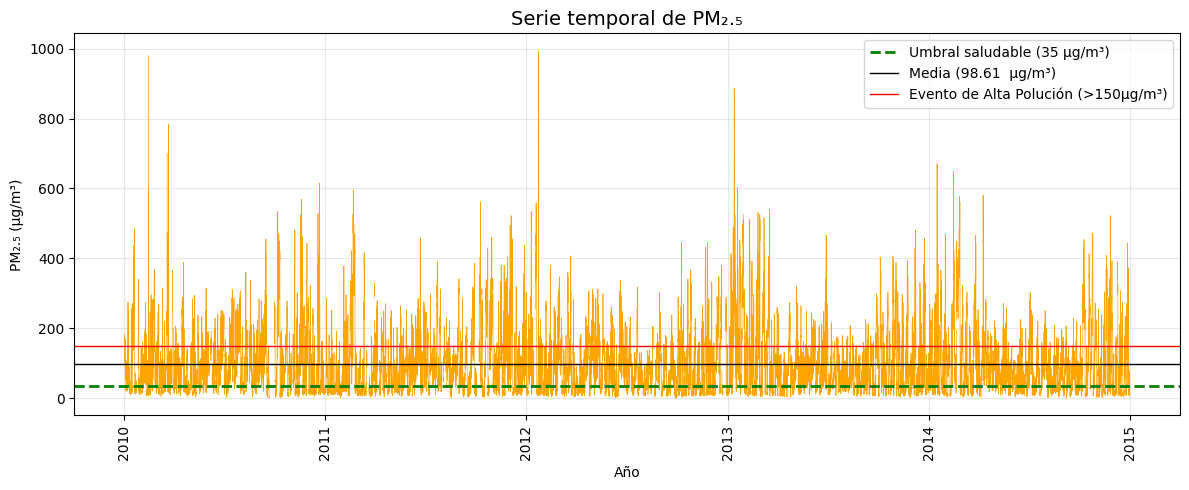

In [29]:
#Serie temporal de pm2.5
plt.figure(figsize=(12, 5))
plt.plot(df['datetime'], df['pm2.5'], color='orange', linewidth=0.5)
plt.axhline(y=35, color='green', linestyle='--', linewidth=2, label='Umbral saludable (35 µg/m³)')
plt.axhline(y= 98.613215, color='black', linestyle='-', linewidth=1, label='Media (98.61  µg/m³)')
plt.axhline(y=150, color='red', linestyle='-', linewidth=1, label='Evento de Alta Polución (>150µg/m³)')
plt.title('Serie temporal de PM₂.₅', fontsize=14)
plt.xlabel('Año')
plt.ylabel('PM₂.₅ (µg/m³)')
plt.xticks(rotation=90)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

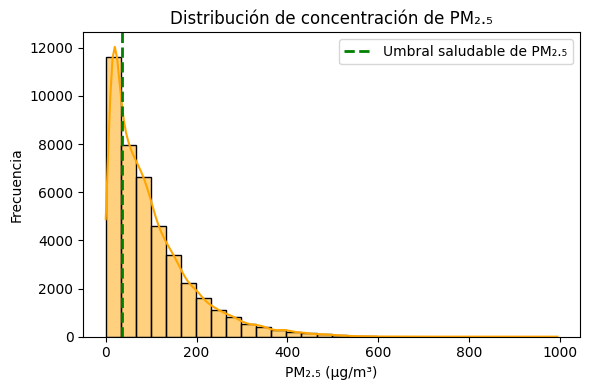

In [30]:
# Histogramas para cada variable
plt.figure(figsize=(6,4))
sns.histplot(df['pm2.5'], bins=30, kde=True, color='orange')
plt.axvline(x=35, color='green', linestyle='--', linewidth=2, label='Umbral saludable de PM₂.₅')
plt.legend()
plt.title('Distribución de concentración de PM₂.₅')
plt.xlabel('PM₂.₅ (µg/m³)')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

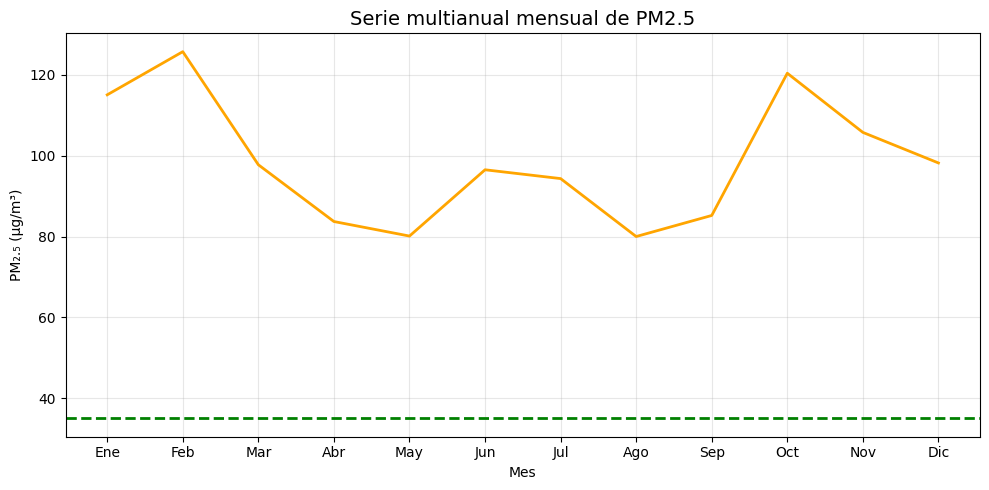

In [31]:
#Serie multianual mensual
pm_por_mes = df.groupby('month')['pm2.5'].mean().reset_index() # Calcular promedio de PM2.5 por mes (agregando todos los años)
meses = ['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic']

plt.figure(figsize=(10, 5))
plt.plot(pm_por_mes['month'], pm_por_mes['pm2.5'], color='orange', linewidth=2)
plt.axhline(y=35, color='green', linestyle='--', linewidth=2, label='Umbral saludable (35 µg/m³)')
plt.title('Serie multianual mensual de PM2.5', fontsize=14)
plt.xlabel('Mes')
plt.ylabel('PM₂.₅ (µg/m³)')
plt.xticks(ticks=range(1,13), labels=meses)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

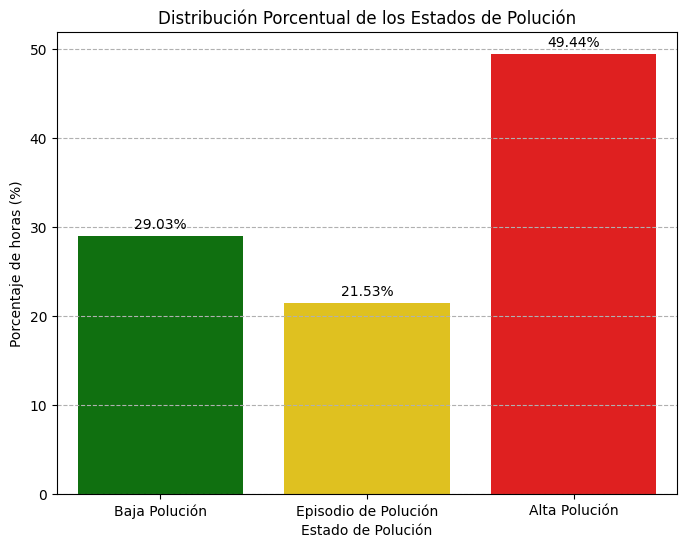

In [32]:
plt.figure(figsize=(8, 6))

# Porcentajes
pm_state_counts = df['pm_state'].value_counts(normalize=True) * 100
pm_state_counts = pm_state_counts.reindex(['1', '2', '3']) # Reorder for better display, matching the provided meanings
colours = {'1': 'green', '2': 'gold', '3': 'red'} # Adjusted colors to match new order if desired, or keep as is

# Map numerical labels to descriptive names
state_labels = {'1': 'Baja Polución', '3': 'Alta Polución', '2': 'Episodio de Polución'}
x_labels = [state_labels[s] for s in pm_state_counts.index]

bars = sns.barplot(
    x=x_labels,    # Use descriptive labels for x-axis
    y=pm_state_counts.values,   # Porcentajes
    hue=pm_state_counts.index,
    palette=colours,
    legend=False
)

for bar in bars.patches: # Etiquetas de porcentaje sobre cada barra
    height = bar.get_height()
    bars.annotate(
        f'{height:.2f}%',
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),
        textcoords='offset points',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.title('Distribución Porcentual de los Estados de Polución')
plt.ylabel('Porcentaje de horas (%)')
plt.xlabel('Estado de Polución')
plt.grid(axis='y', linestyle='--')
plt.show()

## Gráficas exploratorias relacionando la variable principal con las otras variables

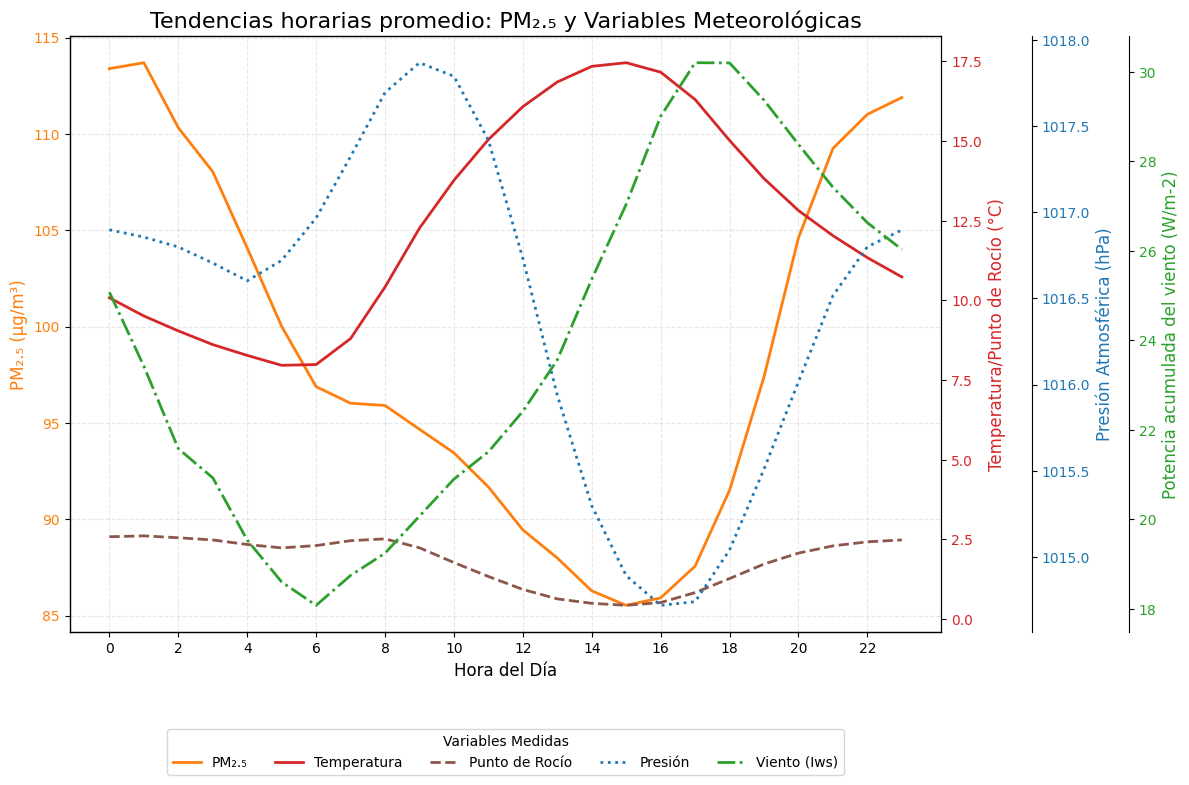

In [33]:
# Calcular los promedios horarios para las variables continuas
variables = ['pm2.5', 'TEMP', 'DEWP', 'PRES', 'Iws']
promedios_hora = df.groupby('hour')[variables].mean()

# Series de promedios diarios
pm25_promedio = promedios_hora['pm2.5']
temp_promedio = promedios_hora['TEMP']
dewp_promedio = promedios_hora['DEWP']
pres_promedio = promedios_hora['PRES']
iws_promedio = promedios_hora['Iws']

horas = promedios_hora.index

# Configurar 4 twin axes
fig, ax1 = plt.subplots(figsize=(12, 7))
# Eje Y1 (ax1): Concentración de PM₂.₅ (Eje Principal a la izquierda)
color_pm25 = 'tab:orange'
ax1.set_xlabel('Hora del Día', fontsize=12)
ax1.set_ylabel('PM₂.₅ (µg/m³)', color=color_pm25, fontsize=12)
ax1.plot(horas, pm25_promedio, color=color_pm25, linewidth=2, label='PM₂.₅')
ax1.tick_params(axis='y', labelcolor=color_pm25)
ax1.grid(alpha=0.3, linestyle='--')

#Eje Y2 (ax2): Temperatura y Punto de Rocío (A la derecha)
ax2 = ax1.twinx()
color_temp = 'tab:red'
ax2.set_ylabel('Temperatura/Punto de Rocío (°C)', color=color_temp, fontsize=12)
ax2.plot(horas, temp_promedio, color='tab:red', linestyle='-', linewidth=2, label='Temperatura')
ax2.plot(horas, dewp_promedio, color='tab:brown', linestyle='--', linewidth=2, label='Punto de Rocío')
ax2.tick_params(axis='y', labelcolor=color_temp)

# Eje Y3 (ax3): Presión Atmosférica (A la derecha)
ax3 = ax1.twinx()
color_pres = 'tab:blue'
ax3.spines['right'].set_position(('outward', 65)) #Evitar superposición con ax2
ax3.set_ylabel('Presión Atmosférica (hPa)', color=color_pres, fontsize=12)
ax3.plot(horas, pres_promedio, color=color_pres, linestyle=':', linewidth=2, label='Presión')
ax3.tick_params(axis='y', labelcolor=color_pres)

# Eje Y 4 (ax4): Velocidad Acumulada del Viento (A la derecha)
ax4 = ax1.twinx()
color_iws = 'tab:green'
ax4.spines['right'].set_position(('outward', 135))
ax4.set_ylabel('Potencia acumulada del viento (W/m-2)', color=color_iws, fontsize=12)
ax4.plot(horas, iws_promedio, color=color_iws, linestyle='-.', linewidth=2, label='Viento (Iws)')
ax4.tick_params(axis='y', labelcolor=color_iws)
plt.title('Tendencias horarias promedio: PM₂.₅ y Variables Meteorológicas', fontsize=16)
ax1.set_xticks(range(0, 24, 2)) # cada 2 horas
fig.tight_layout()
lines_ax1, labels_ax1 = ax1.get_legend_handles_labels()
lines_ax2, labels_ax2 = ax2.get_legend_handles_labels()
lines_ax3, labels_ax3 = ax3.get_legend_handles_labels()
lines_ax4, labels_ax4 = ax4.get_legend_handles_labels()
ax1.legend(lines_ax1 + lines_ax2 + lines_ax3 + lines_ax4, labels_ax1 + labels_ax2 + labels_ax3 + labels_ax4, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, title='Variables Medidas')
plt.show()

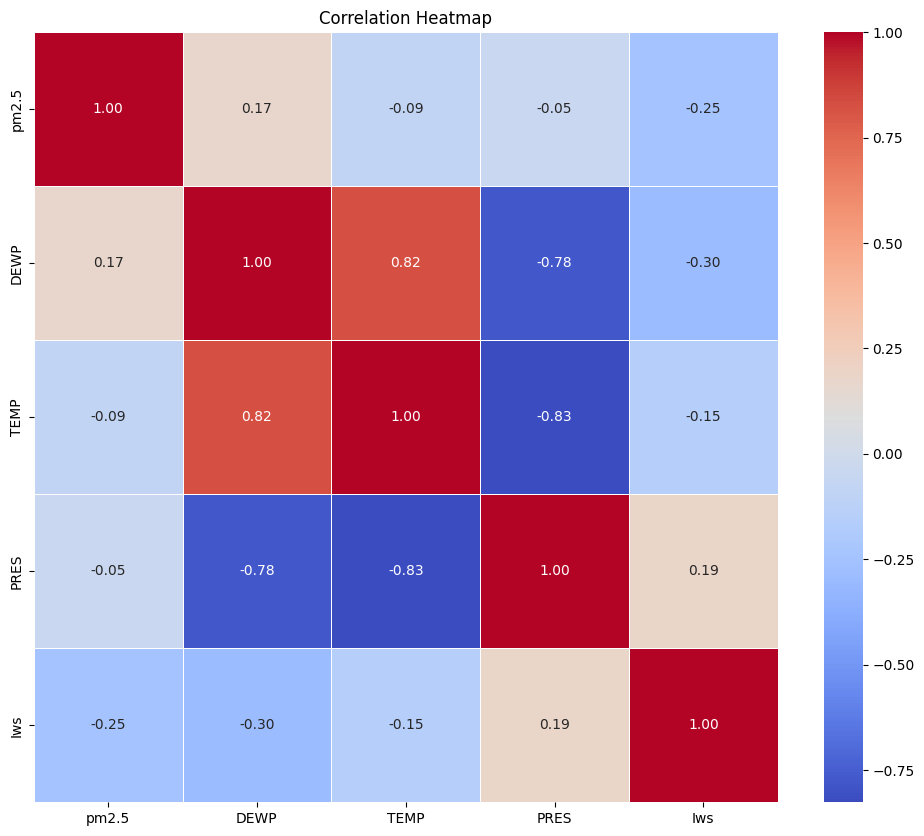

In [34]:
# Select only numerical columns for correlation calculation
numeric_df = df.select_dtypes(include=['number'])

# Exclude 'snow', 'rain', 'No', 'day', 'month', 'year', 'hour', 'pm_state', and 'pm2.5_scaled' columns if they exist in the numerical DataFrame
columns_to_exclude = ['snow', 'rain', 'No', 'day', 'month', 'year', 'hour', 'pm_state', 'pm2.5_scaled']
numeric_df_filtered = numeric_df.drop(columns=[col for col in columns_to_exclude if col in numeric_df.columns])

# Scale the numerical variables
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df_filtered)
scaled_df = pd.DataFrame(scaled_data, columns=numeric_df_filtered.columns, index=numeric_df_filtered.index)

# Calculate the correlation matrix on the scaled data
correlation_matrix = scaled_df.corr()

# Generate the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

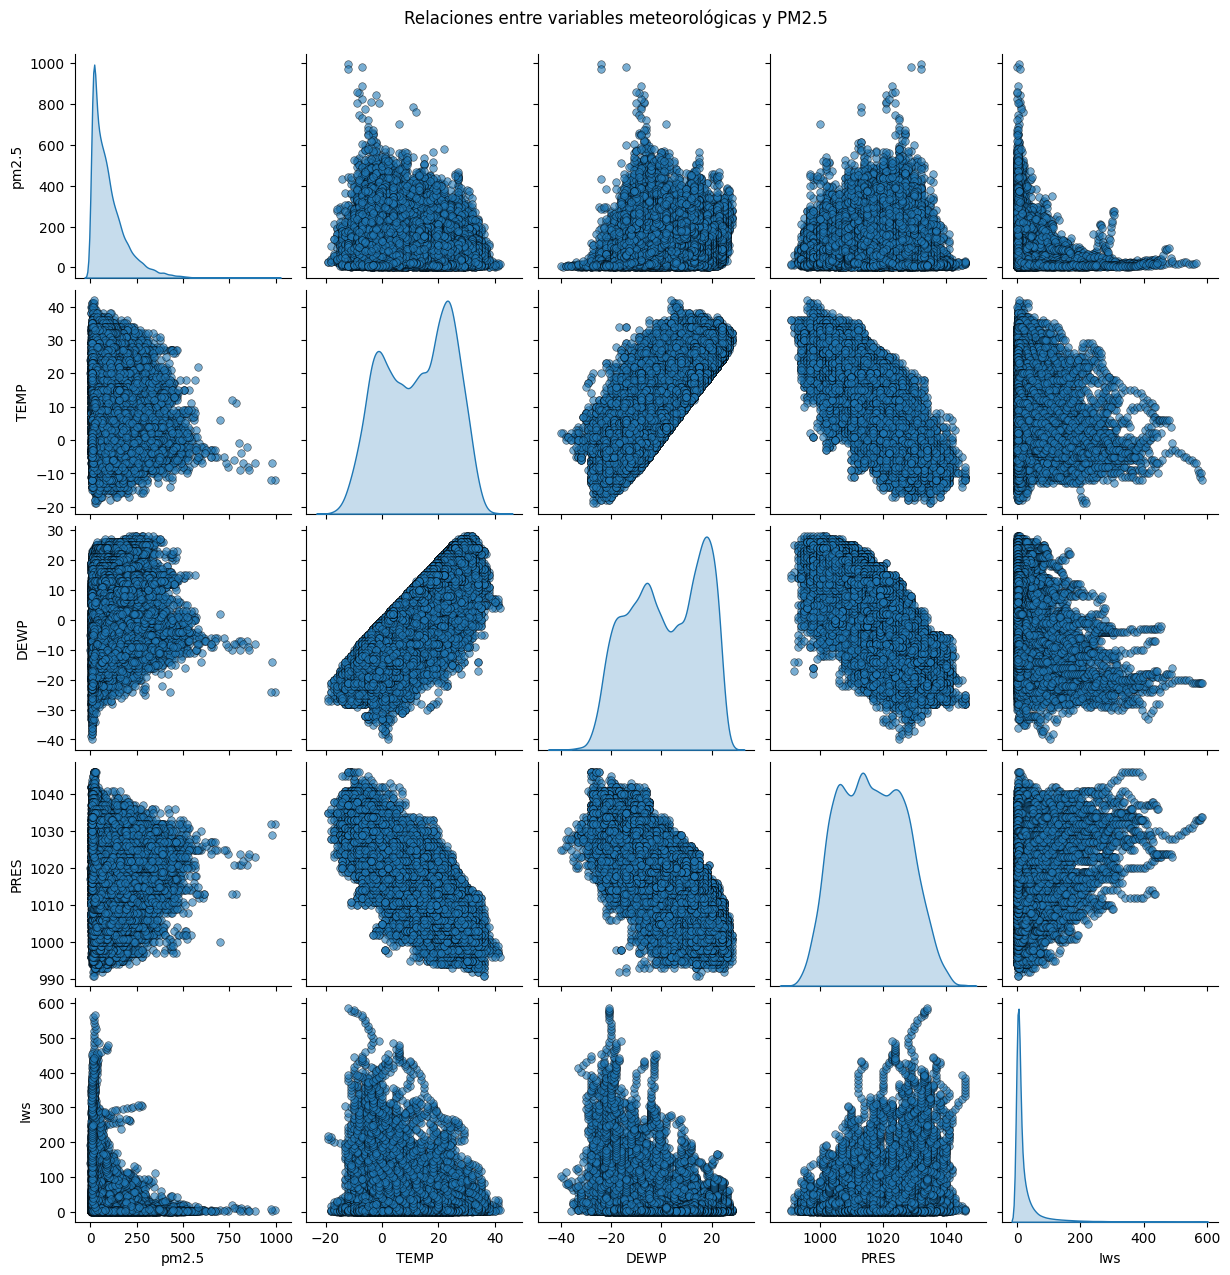

In [35]:
# Filtrar solo las columnas de interés
df_subset = df[variables]

# Crear el pairplot
sns.pairplot(df_subset, diag_kind='kde', plot_kws={'alpha':0.6, 's':30, 'edgecolor':'k'})

# Mostrar la gráfica
plt.suptitle('Relaciones entre variables meteorológicas y PM2.5', y=1.02)
plt.show()

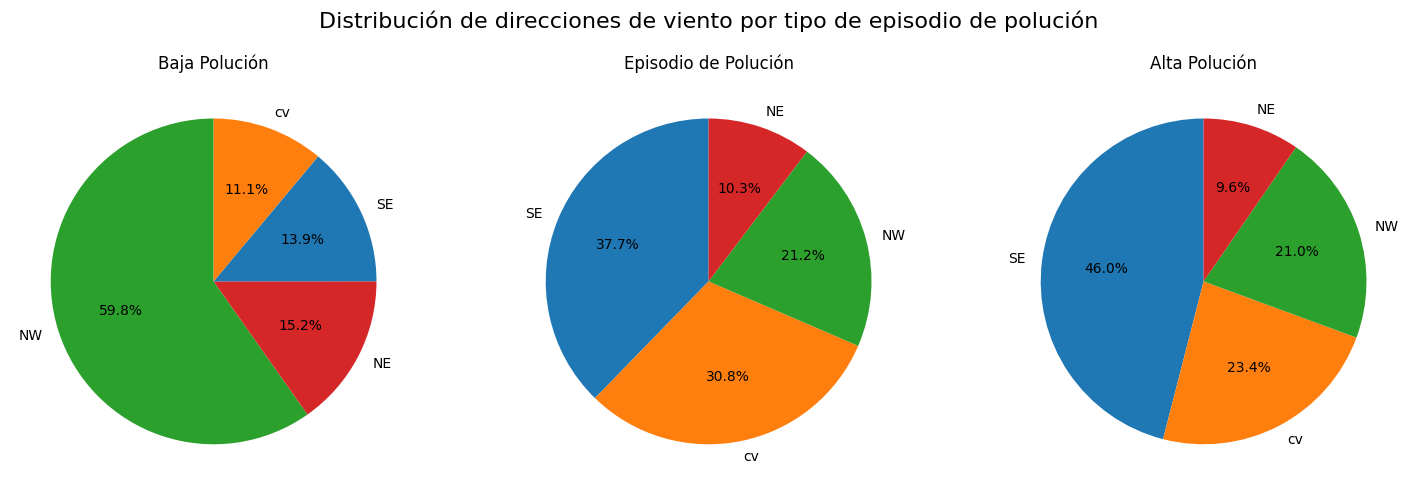

In [36]:
# Distribución de direcciones del viento por tipo de episodio
df_valid = df.dropna(subset=['cbwd', 'pm_state'])

estados_polucion = ['1', '2', '3']

# Map numerical labels to descriptive names for titles
state_title_labels = {'1': 'Baja Polución', '2': 'Episodio de Polución', '3': 'Alta Polución'}

#Mapeo global de colores para las direcciones del viento
# Obtener todas las direcciones únicas
direcciones_unicas = df_valid['cbwd'].unique()

cmap = plt.cm.tab10
colores_direcciones = {dir_viento: cmap(i) for i, dir_viento in enumerate(direcciones_unicas)}

# Grafico de torta
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Distribución de direcciones de viento por tipo de episodio de polución', fontsize=16)

# Iterar sobre cada estado de polución
for ax, estado in zip(axes, estados_polucion):
    datos = df_valid[df_valid['pm_state'] == estado]['cbwd'].value_counts(normalize=True) * 100
    colores_para_rebanadas = [colores_direcciones[d] for d in datos.index]
    wedges, texts, autotexts = ax.pie(datos.values, labels=datos.index, autopct='%1.1f%%',startangle=90, colors=colores_para_rebanadas)
    ax.set_title(f'{state_title_labels[estado]}') # Use the descriptive label here
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

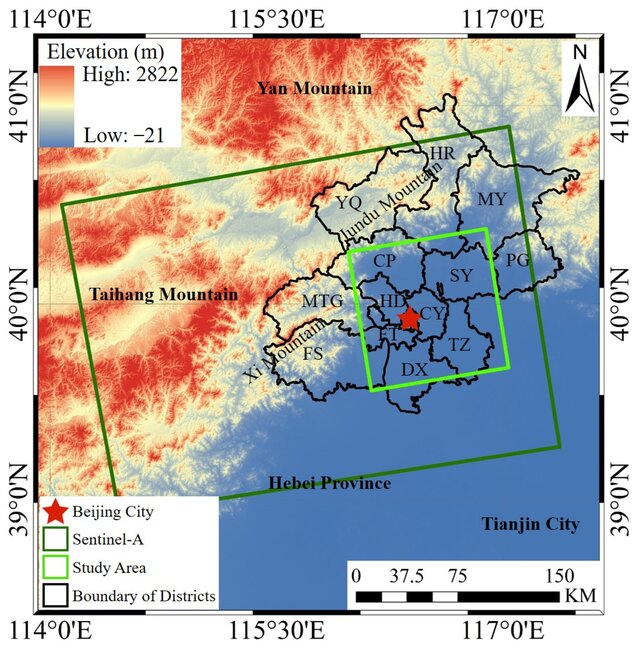

In [37]:
from IPython.display import Image
display(Image(filename='/content/drive/MyDrive/intro_cienciadatos/pekin_dem.jpg', width=600))

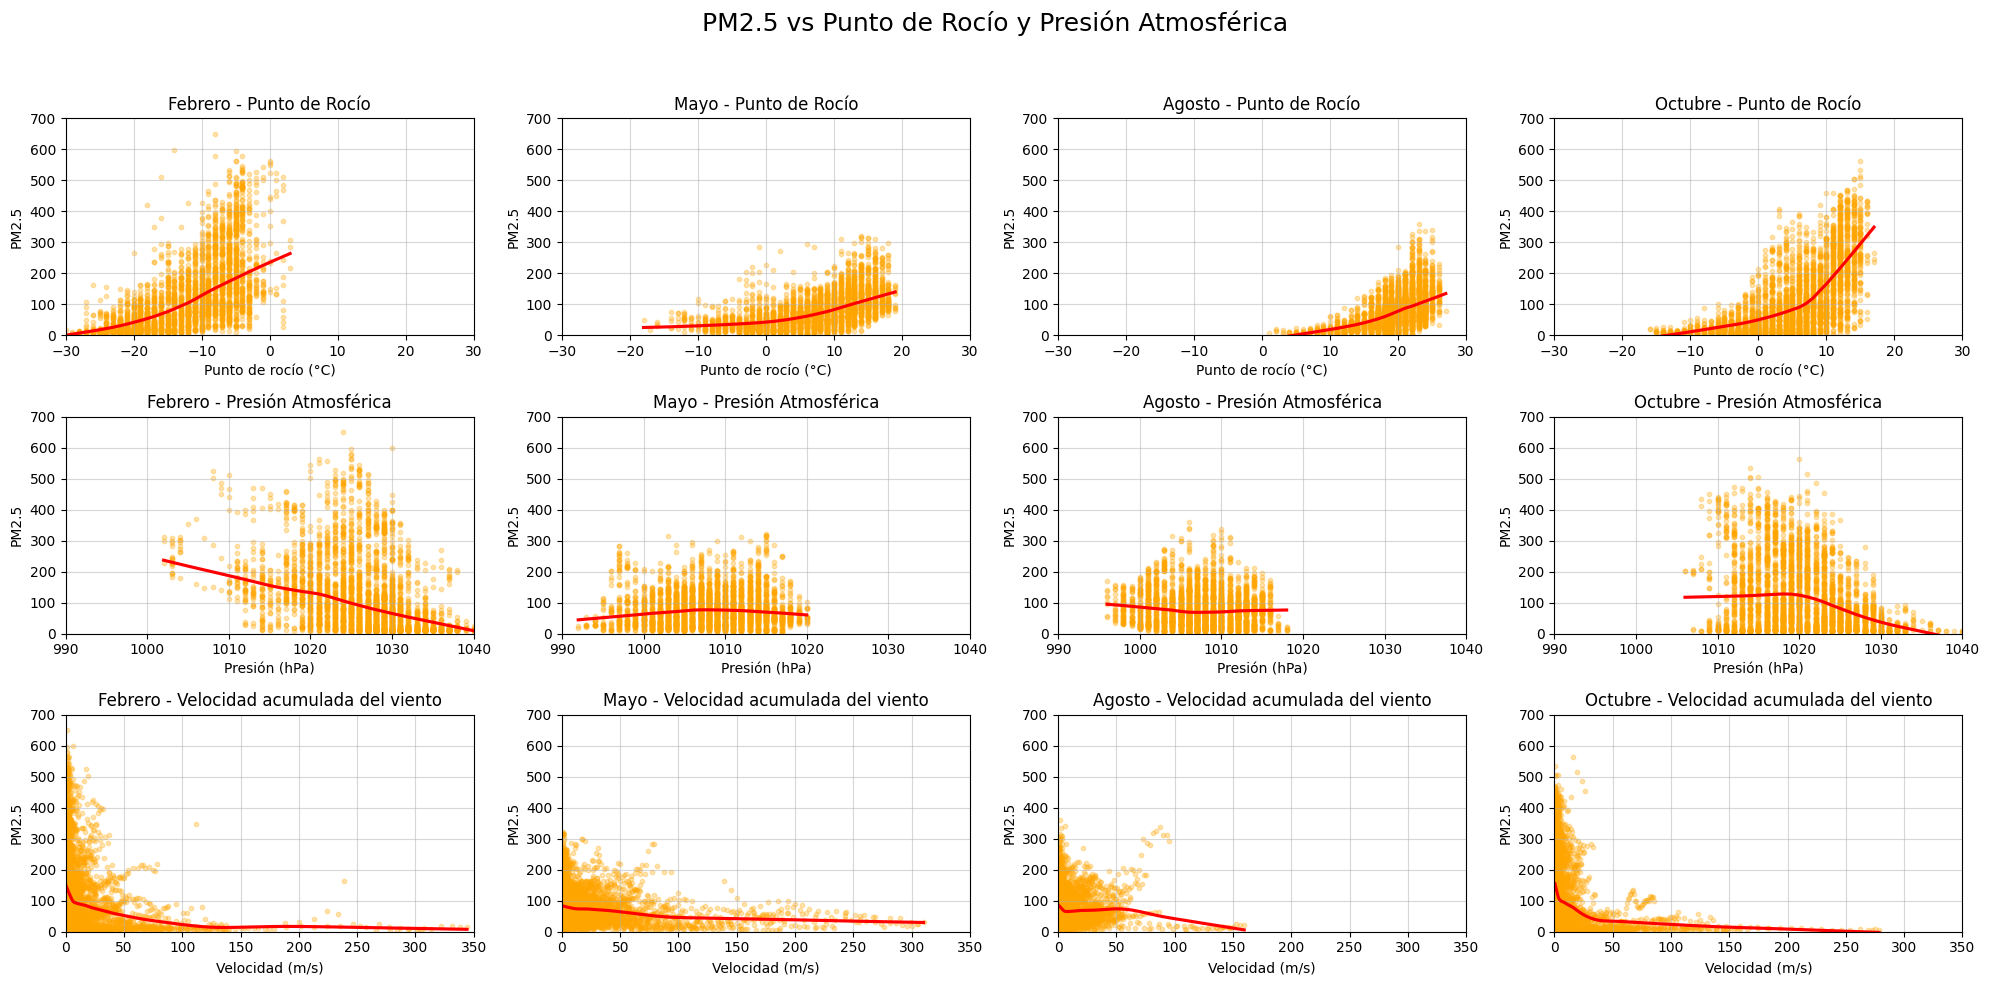

In [38]:
# Meses a graficar
meses = {2: 'Febrero', 5: 'Mayo', 8: 'Agosto', 10: 'Octubre'} #Los meses donde se evidencian picos en las concentraciones de PM 2.5

# 2 filas y 4 columnas
fig, axes = plt.subplots(3, 4, figsize=(20, 10))
fig.suptitle('PM2.5 vs Punto de Rocío y Presión Atmosférica', fontsize=18)

for i, (mes_num, mes_nombre) in enumerate(meses.items()):
    df_mes = df[df['month'] == mes_num]

    # PM2.5 vs Punto de rocío
    ax1 = axes[0, i]
    sns.regplot(data=df_mes, x='DEWP', y='pm2.5', lowess=True, scatter_kws={'color': 'orange', 'alpha': 0.3, 's': 10}, line_kws={'color': 'red'}, ax=ax1)
    ax1.set_title(f'{mes_nombre} - Punto de Rocío')
    ax1.set_xlabel('Punto de rocío (°C)')
    ax1.set_ylabel('PM2.5')
    ax1.set_xlim(-30, 30)
    ax1.set_ylim(0, 700)
    ax1.grid(True, alpha=0.5)

    # PM2.5 vs Presión Atm
    ax2 = axes[1, i]
    sns.regplot(data=df_mes, x='PRES', y='pm2.5',lowess=True, scatter_kws={'color': 'orange', 'alpha': 0.3, 's': 10}, line_kws={'color': 'red'}, ax=ax2)
    ax2.set_title(f'{mes_nombre} - Presión Atmosférica')
    ax2.set_xlabel('Presión (hPa)')
    ax2.set_ylabel('PM2.5')
    ax2.set_xlim(990, 1040)
    ax2.set_ylim(0, 700)
    ax2.grid(True, alpha=0.5)

    # PM2.5 vs Vel viento
    ax3 = axes[2, i]
    sns.regplot(data=df_mes, x='Iws', y='pm2.5',lowess=True, scatter_kws={'color': 'orange', 'alpha': 0.3, 's': 10}, line_kws={'color': 'red'}, ax=ax3)
    ax3.set_title(f'{mes_nombre} - Velocidad acumulada del viento')
    ax3.set_xlabel('Velocidad (m/s)')
    ax3.set_ylabel('PM2.5')
    ax3.set_xlim(0, 350)
    ax3.set_ylim(0, 700)
    ax3.grid(True, alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

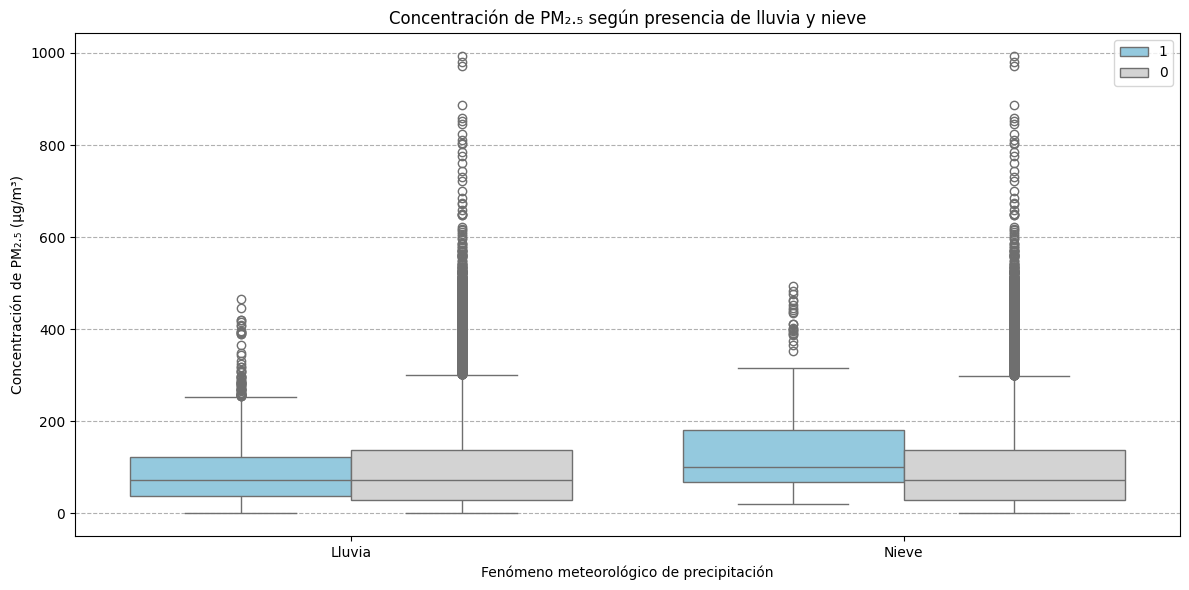

In [39]:
#Boxplots de PM2.5 según ocurrencia de precipitación
df_lluvia = df[['pm2.5', 'rain']].copy()
df_lluvia['Fenómeno'] = 'Lluvia'
df_lluvia['Estado'] = df_lluvia['rain']

df_nieve = df[['pm2.5', 'snow']].copy()
df_nieve['Fenómeno'] = 'Nieve'
df_nieve['Estado'] = df_nieve['snow']

df_comb = pd.concat([df_lluvia, df_nieve], ignore_index=True)

plt.figure(figsize=(12, 6))
sns.boxplot(x='Fenómeno', y='pm2.5', hue='Estado', data=df_comb, order=['Lluvia', 'Nieve'], hue_order=['1', '0'], palette={'1': 'skyblue', '0': 'lightgray'})
plt.title('Concentración de PM₂.₅ según presencia de lluvia y nieve')
plt.ylabel('Concentración de PM₂.₅ (µg/m³)')
plt.xlabel('Fenómeno meteorológico de precipitación')
plt.grid(axis='y', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

# <strong> Detección y análisis de datos atípicos </strong>


# Método de Rango Intercuartílico


Límite Superior IQR (+1.5 x IQR): 299.00 µg/m³
Total de valores atípicos altos (> 299.00 µg/m³): 1773
% de atípicos altos (> 299.00 µg/m³): 4.0457283680175244

Límite Superior IQR (+4.6 x IQR): 633.80 µg/m³
Total de valores atípicos altos (> 633.80 µg/m³): 26
% de atípicos altos (> 633.80 µg/m³): 0.05932822197882439


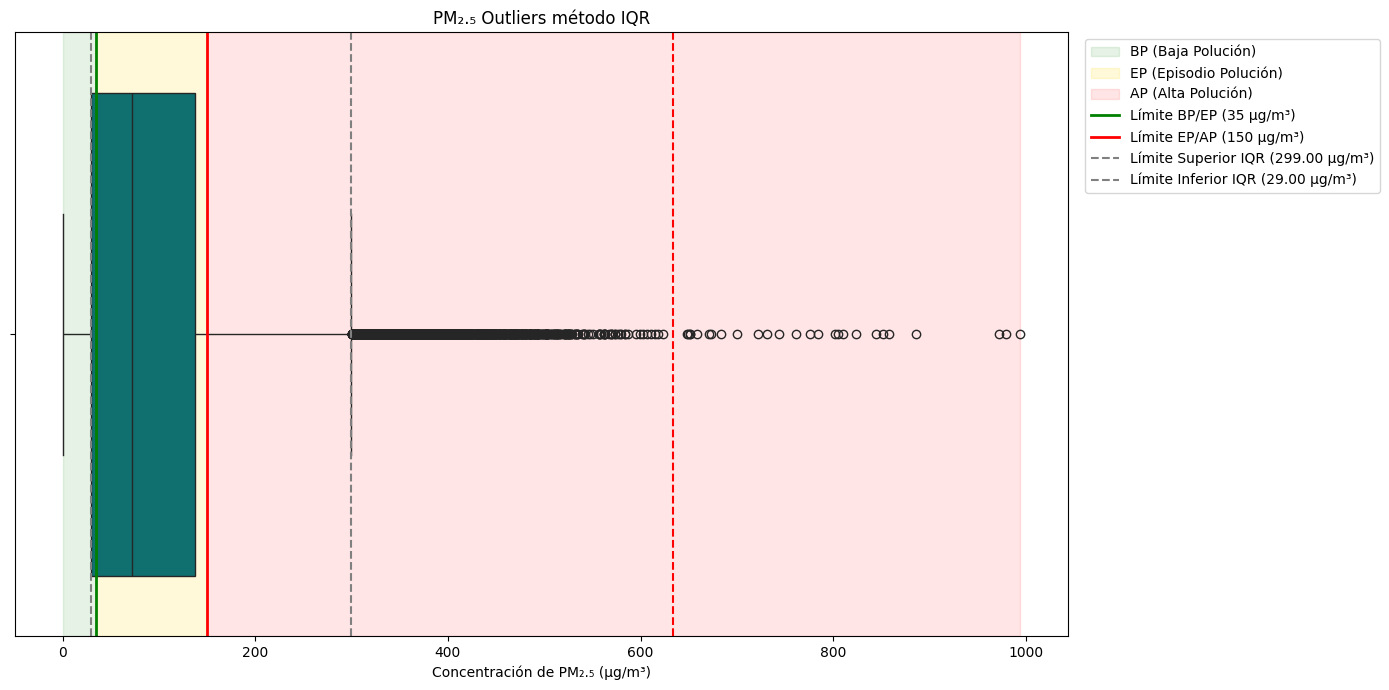

In [40]:
#Eliminar NaNs de la columna de pm 2.5
pm25_clean = df['pm2.5'].dropna()

#IQR
Q1 = pm25_clean.quantile(0.25)
Q3 = pm25_clean.quantile(0.75)
IQR = Q3 - Q1

#Límites
lim_inf = Q1 #pm2.5 no puede ser menor a 0
lim_sup = Q3 + 1.5 * IQR
lim_sup2 = Q3 + 4.6 * IQR

#Límites Categóricos
LIM_EP = 35  # Límite de Baja Polución a Episodio de Polución
LIM_AP = 150 # Límite de Episodio de Polución a Alta Polución

df['outlier_iqr'] = (df['pm2.5'] < lim_inf) | (df['pm2.5'] > lim_sup)
num_atipicos= (df['pm2.5'] > lim_sup).sum()
porcentaje_atipicos = (num_atipicos/ len(df)) * 100

num_atipicos2= (df['pm2.5'] > lim_sup2).sum()
porcentaje_atipicos2 = (num_atipicos2/ len(df)) * 100

print(f"\nLímite Superior IQR (+1.5 x IQR): {lim_sup:.2f} µg/m³")
print(f"Total de valores atípicos altos (> {lim_sup:.2f} µg/m³): {num_atipicos}")
print(f"% de atípicos altos (> {lim_sup:.2f} µg/m³): {porcentaje_atipicos}")
print(f"\nLímite Superior IQR (+4.6 x IQR): {lim_sup2:.2f} µg/m³")
print(f"Total de valores atípicos altos (> {lim_sup2:.2f} µg/m³): {num_atipicos2}")
print(f"% de atípicos altos (> {lim_sup2:.2f} µg/m³): {porcentaje_atipicos2}")


#Gráfica
plt.figure(figsize=(14, 7))
sns.boxplot(x=pm25_clean, color='teal')
plt.axvspan(0, LIM_EP, color='green', alpha=0.1, label='BP (Baja Polución)')
plt.axvspan(LIM_EP, LIM_AP, color='gold', alpha=0.15, label='EP (Episodio Polución)')
plt.axvspan(LIM_AP, pm25_clean.max(), color='red', alpha=0.1, label='AP (Alta Polución)')
plt.axvline(LIM_EP, color='green', linestyle='-', linewidth=2, label=f'Límite BP/EP ({LIM_EP:.0f} µg/m³)')
plt.axvline(LIM_AP, color='red', linestyle='-', linewidth=2, label=f'Límite EP/AP ({LIM_AP:.0f} µg/m³)')
plt.axvline(lim_sup, color='gray', linestyle='--', linewidth=1.5, label=f'Límite Superior IQR ({lim_sup:.2f} µg/m³)')
plt.axvline(lim_inf, color='gray', linestyle='--', linewidth=1.5, label=f'Límite Inferior IQR ({lim_inf:.2f} µg/m³)')
plt.axvline(lim_sup2, color='red', linestyle='--', linewidth=1.5)
plt.xlabel('Concentración de PM₂.₅ (µg/m³)')
plt.title('PM₂.₅ Outliers método IQR')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Método de Isolation Forest

Conteo de anomalías:
anomaly
 1    41339
-1      418
Name: count, dtype: int64

Proporción de outliers: 0.010010297674641377


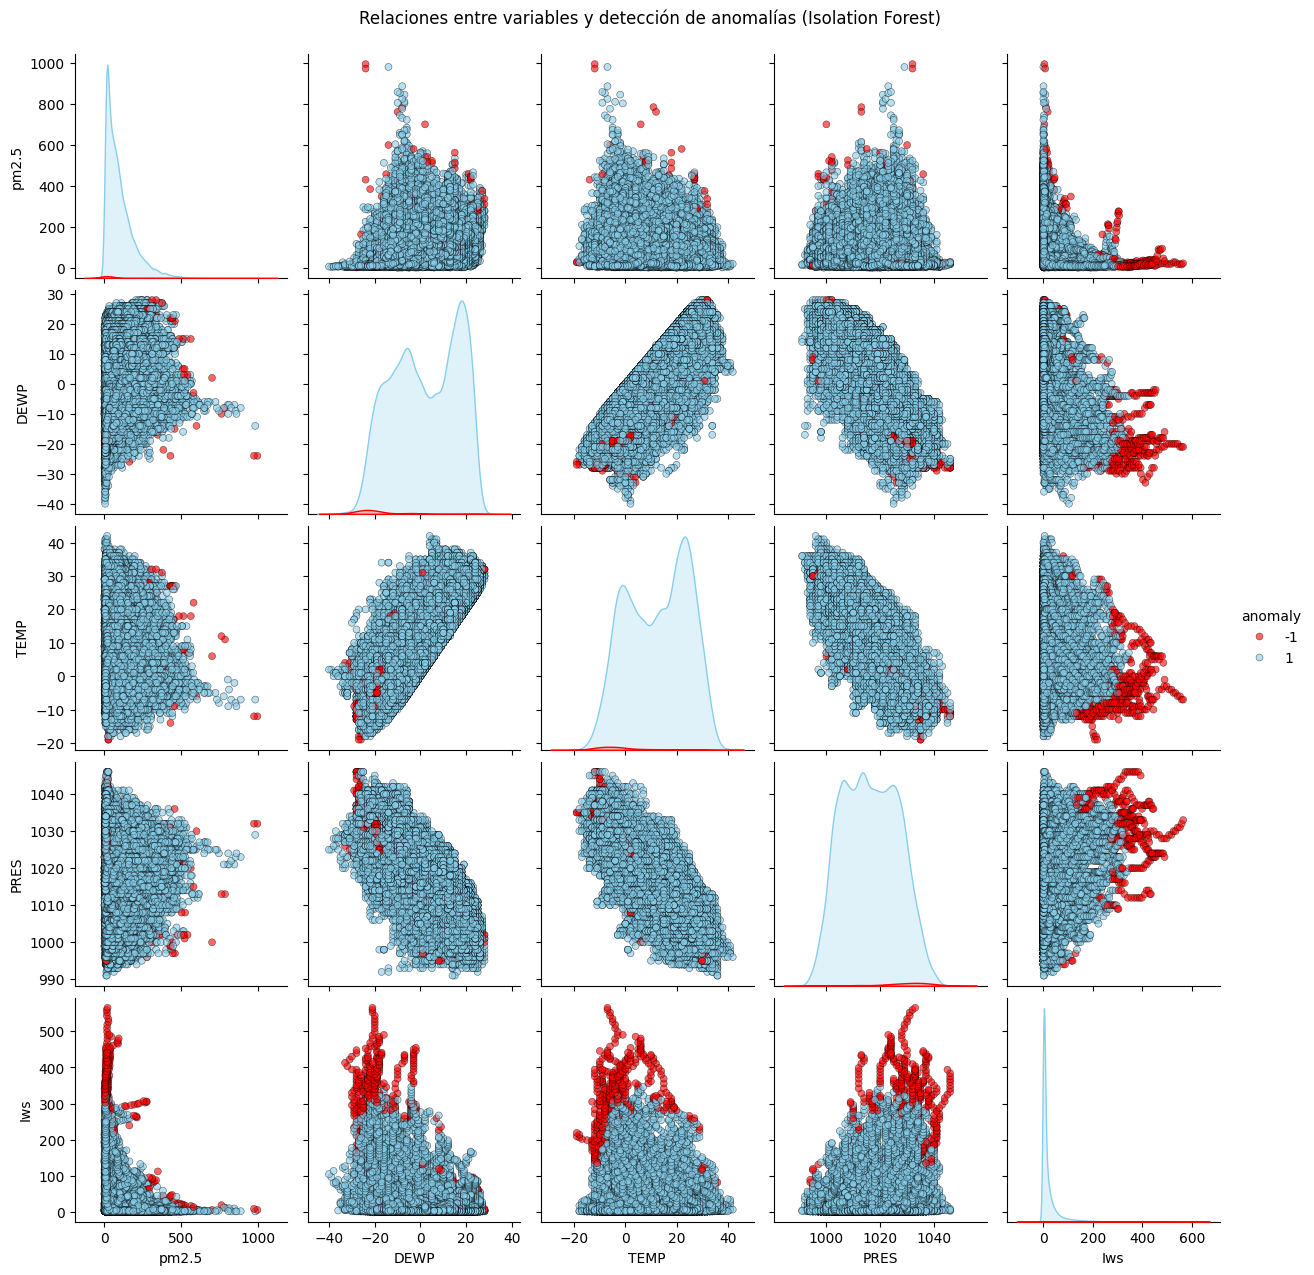

In [41]:
# Seleccionar variables numéricas
num_vars = ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws']
df_num = df[num_vars].dropna()  # eliminar filas con NaN

# Estandarizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_num)

# Modelo Isolation Forest
iso = IsolationForest(contamination=0.01, n_estimators=200, random_state=42)
iso.fit(X_scaled)

# Predicciones
df_num['anomaly'] = iso.predict(X_scaled)
df_num['score'] = iso.decision_function(X_scaled)

# Agregar resultados al DataFrame original
df.loc[df_num.index, 'anomaly'] = df_num['anomaly']
df.loc[df_num.index, 'score'] = df_num['score']

print("Conteo de anomalías:")
print(df_num['anomaly'].value_counts())
print("\nProporción de outliers:", (df_num['anomaly'] == -1).mean())

# Mapear colores: azul = normal, rojo = outlier
palette = {1: 'skyblue', -1: 'red'}

sns.pairplot(data=df_num, vars=num_vars, hue='anomaly', palette=palette, diag_kind='kde', plot_kws={'alpha':0.6, 's':25, 'edgecolor':'k'})

plt.suptitle('Relaciones entre variables y detección de anomalías (Isolation Forest)', y=1.02)
plt.show()


Imputación de datos faltantes

In [42]:
file_path = '/content/drive/MyDrive/intro_cienciadatos/dataset/pm25_dataset_limpio.csv'
df = pd.read_csv(file_path)
display(df.head())

No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd    Iws  snow  \
0   1  2010      1    1     0    NaN   -21 -11.0  1021.0   NW   1.79     0   
1   2  2010      1    1     1    NaN   -21 -12.0  1020.0   NW   4.92     0   
2   3  2010      1    1     2    NaN   -21 -11.0  1019.0   NW   6.71     0   
3   4  2010      1    1     3    NaN   -21 -14.0  1019.0   NW   9.84     0   
4   5  2010      1    1     4    NaN   -20 -12.0  1018.0   NW  12.97     0   

   rain  pm_state  
0     0       NaN  
1     0       NaN  
2     0       NaN  
3     0       NaN  
4     0       NaN

In [43]:
Q1 = df['pm2.5'].quantile(0.25)
Q3 = df['pm2.5'].quantile(0.75)
IQR = Q3 - Q1
upper_limit = Q3 + 4.6 * IQR
# Remove values above the upper limit
df = df[df['pm2.5'] <= upper_limit]
# Crear un nuevo DataFrame eliminando todas las filas con valores NaN
# Drop the 'No' column as it's an identifier and not needed for analysis
df = df.drop(columns=['No'], errors='ignore')
print(f"Shape del DataFrame después de eliminar la columna 'No': {df.shape}")

df_cleaned = df.dropna()
print(f"Shape del DataFrame después de eliminar NaNs: {df_cleaned.shape}")

display(df_cleaned.head())

Shape del DataFrame después de eliminar la columna 'No': (41731, 13)
Shape del DataFrame después de eliminar NaNs: (41731, 13)


year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd   Iws  snow  rain  \
24  2010      1    2     0  129.0   -16  -4.0  1020.0   SE  1.79     0     0   
25  2010      1    2     1  148.0   -15  -4.0  1020.0   SE  2.68     0     0   
26  2010      1    2     2  159.0   -11  -5.0  1021.0   SE  3.57     0     0   
27  2010      1    2     3  181.0    -7  -5.0  1022.0   SE  5.36     1     0   
28  2010      1    2     4  138.0    -7  -5.0  1022.0   SE  6.25     1     0   

    pm_state  
24       3.0  
25       3.0  
26       2.0  
27       2.0  
28       3.0

Estacionalidad

In [44]:
df_pollution_events = df[df['pm_state'].isin([3.0])]
pollution_events_per_year = df_pollution_events['year'].value_counts().sort_index()
print("Number of high pollution events per year:")
display(pollution_events_per_year)

Number of high pollution events per year:


year
2010    4080
2011    3748
2012    4031
2013    4398
2014    4389
Name: count, dtype: int64

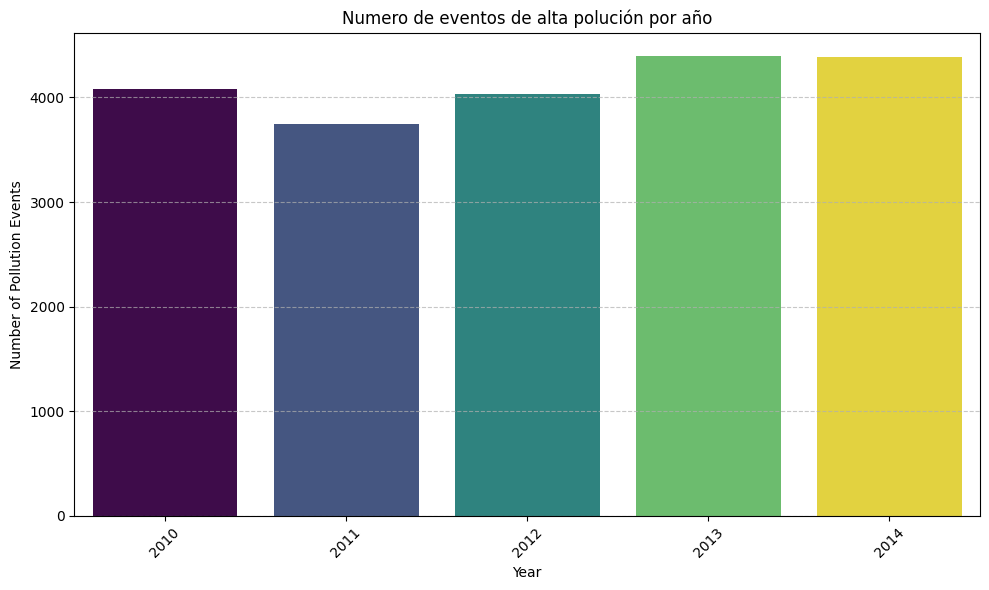

In [45]:
plt.figure(figsize=(10, 6))
sns.barplot(x=pollution_events_per_year.index, y=pollution_events_per_year.values, hue=pollution_events_per_year.index, palette='viridis', legend=False)
plt.title('Numero de eventos de alta polución por año')
plt.xlabel('Year')
plt.ylabel('Number of Pollution Events')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

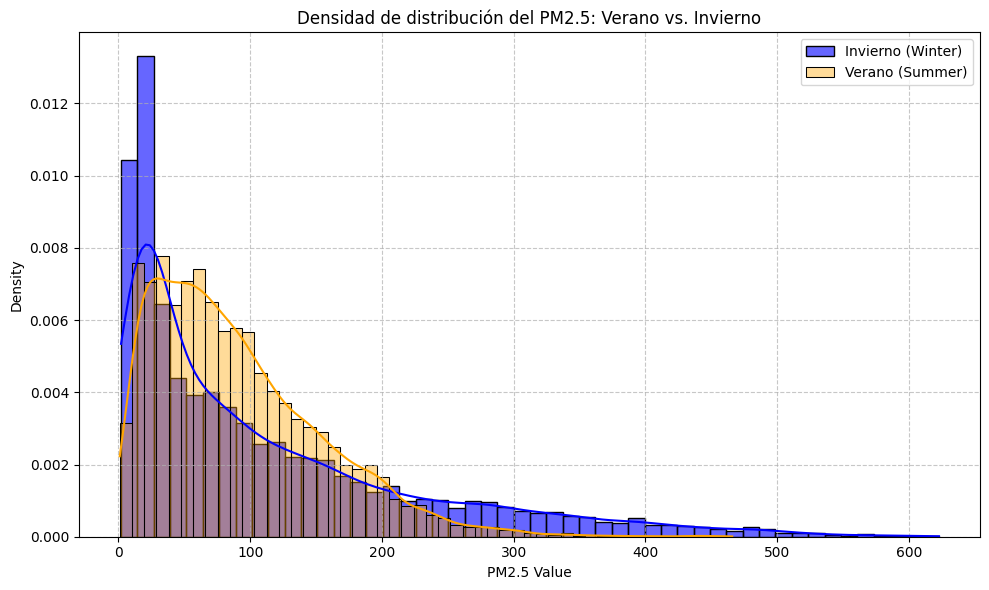

In [46]:
#Crear columna con estaciones
def get_season(month):
    if 3 <= month <= 5:
        return 'Primavera'
    elif 6 <= month <= 8:
        return 'Verano'
    elif 9 <= month <= 11:
        return 'Otoño'
    else:
        return 'Invierno'
df['season'] = df['month'].apply(get_season)

# Filtrar para Verano (Summer) e Invierno (Winter) usando los valores originales de pm2.5
df_summer = df[df['season'] == 'Verano']
df_winter = df[df['season'] == 'Invierno']

plt.figure(figsize=(10, 6))

# Plot para la distribución de PM2.5 durante el Invierno primero (como base)
sns.histplot(df_winter['pm2.5'].dropna(), bins=50, kde=True, color='blue', edgecolor='black', stat='density', label='Invierno (Winter)', alpha=0.6)

# Plot para la distribución de PM2.5 durante el Verano encima para mejor visibilidad
sns.histplot(df_summer['pm2.5'].dropna(), bins=50, kde=True, color='orange', edgecolor='black', stat='density', label='Verano (Summer)', alpha=0.4) # Adjusted alpha for summer

plt.title('Densidad de distribución del PM2.5: Verano vs. Invierno')
plt.xlabel('PM2.5 Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

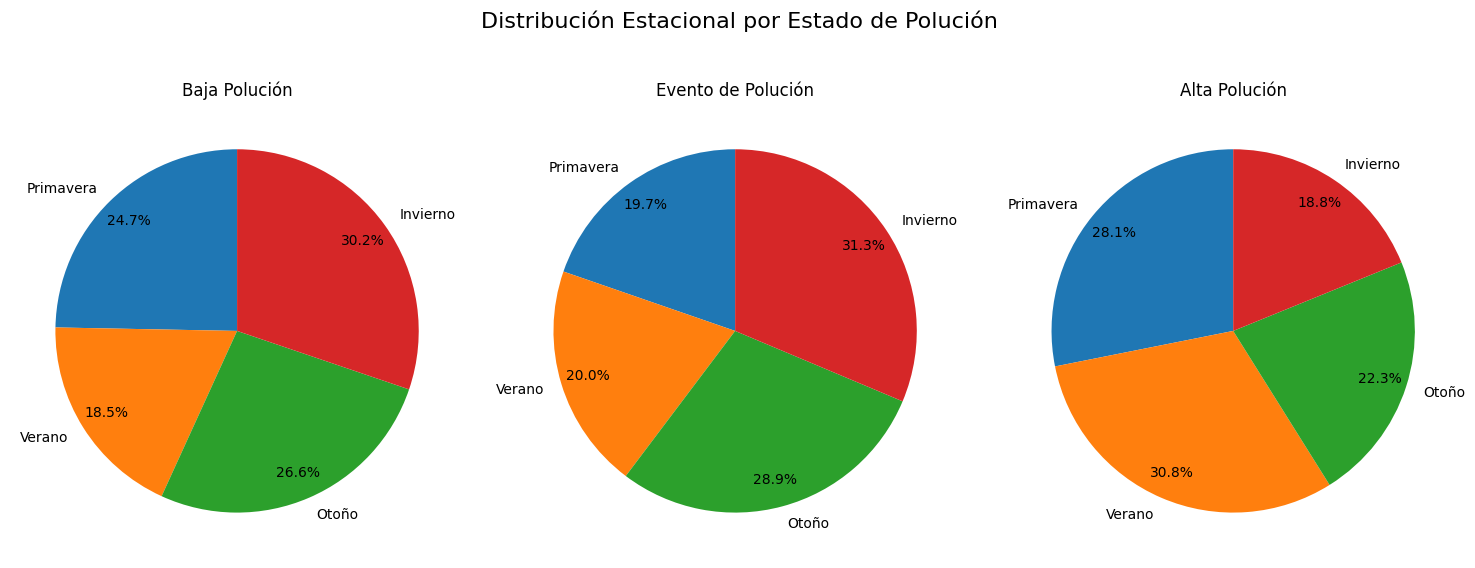

In [47]:
unique_pm_states = df['pm_state'].dropna().unique()

# Sort pm_states for consistent plot order, if they are numerical
if pd.api.types.is_numeric_dtype(unique_pm_states):
    unique_pm_states.sort()

# Define a consistent order for the seasons
ordered_seasons = ['Primavera', 'Verano', 'Otoño', 'Invierno']

# Mapping for pm_state titles
pm_state_titles = {
    1.0: 'Baja Polución',
    2.0: 'Evento de Polución',
    3.0: 'Alta Polución'
}

# Create subplots, one for each pm_state
fig, axes = plt.subplots(1, len(unique_pm_states), figsize=(5 * len(unique_pm_states), 6))
fig.suptitle('Distribución Estacional por Estado de Polución', fontsize=16)

# Ensure axes is an array even for a single subplot
if len(unique_pm_states) == 1:
    axes = [axes]

for i, pm_state_value in enumerate(unique_pm_states):
    # Filter data for the current pm_state and drop NaNs in 'season'
    df_state_season = df[df['pm_state'] == pm_state_value].dropna(subset=['season'])

    # Get the descriptive title for the current pm_state
    title = pm_state_titles.get(pm_state_value, f'PM State: {pm_state_value}')

    if not df_state_season.empty:
        # Calculate season distribution for the state
        datos_season_state = df_state_season['season'].value_counts(normalize=True).reindex(ordered_seasons, fill_value=0) * 100

        # Plotting the pie chart
        wedges, texts, autotexts = axes[i].pie(datos_season_state.values, labels=datos_season_state.index, autopct='%1.1f%%',
                                               startangle=90, pctdistance=0.85)
        axes[i].set_title(title)
        # Ensure text color is black for better readability
        for autotext in autotexts:
            autotext.set_color('black')
    else:
        axes[i].text(0.5, 0.5, f'No hay datos de estación para {title}', horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes, fontsize=12)
        axes[i].set_title(title)

plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

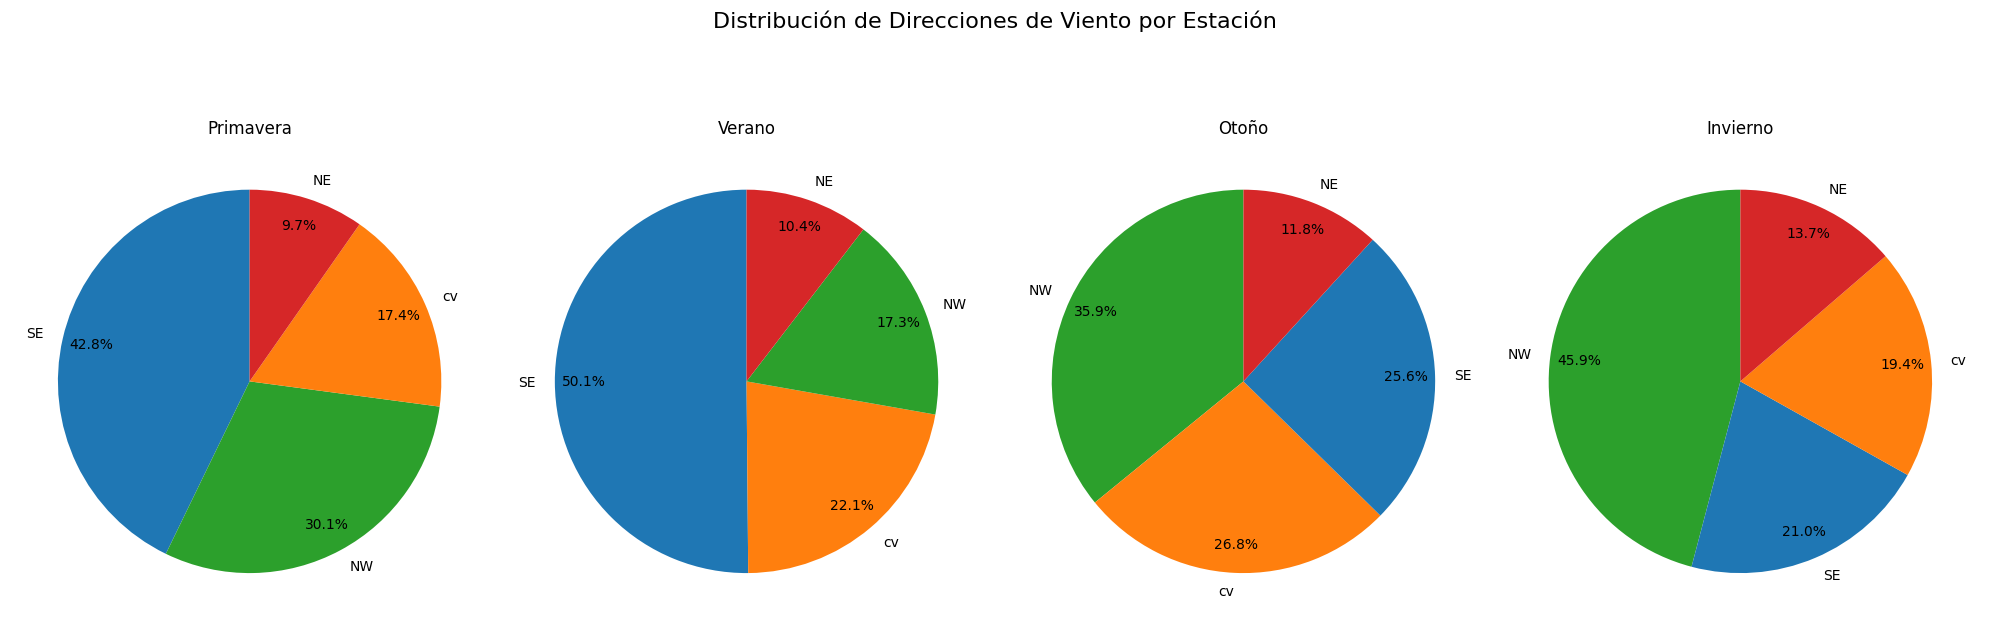

In [48]:
# Get all unique wind directions for consistent color mapping
# Ensure cbwd column is clean before getting unique directions
df_temp_cleaned = df.dropna(subset=['cbwd'])
all_unique_directions = df_temp_cleaned['cbwd'].unique()

# Global color mapping for wind directions
cmap = plt.cm.tab10
colores_direcciones = {dir_viento: cmap(i) for i, dir_viento in enumerate(all_unique_directions)}

# Get unique seasons in the order specified
ordered_seasons = ['Primavera', 'Verano', 'Otoño', 'Invierno']

# Create subplots, one for each season
fig, axes = plt.subplots(1, len(ordered_seasons), figsize=(20, 7))
fig.suptitle('Distribución de Direcciones de Viento por Estación', fontsize=16)

# Ensure axes is an array even for a single subplot
if len(ordered_seasons) == 1:
    axes = [axes]

for i, season_name in enumerate(ordered_seasons):
    # Filter data for the current season and drop NaNs in 'cbwd'
    df_season = df[df['season'] == season_name].dropna(subset=['cbwd'])

    if not df_season.empty:
        # Calculate wind direction distribution for the season
        datos_season = df_season['cbwd'].value_counts(normalize=True) * 100
        colores_para_rebanadas = [colores_direcciones[d] for d in datos_season.index]

        # Plotting the pie chart
        wedges, texts, autotexts = axes[i].pie(datos_season.values, labels=datos_season.index, autopct='%1.1f%%',
                                               startangle=90, colors=colores_para_rebanadas,
                                               pctdistance=0.85)
        axes[i].set_title(season_name)
        # Ensure text color is black for better readability
        for autotext in autotexts:
            autotext.set_color('black')
    else:
        axes[i].text(0.5, 0.5, f'No hay datos para {season_name}', horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes, fontsize=12)
        axes[i].set_title(season_name)

plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

Dirección del viento y velocidad acumulada

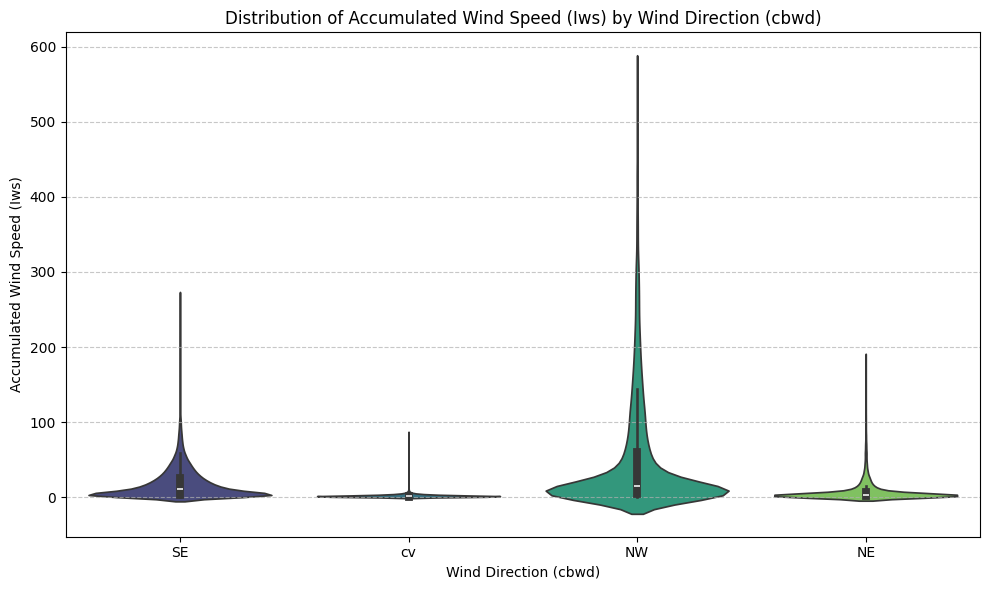

In [49]:
# Ensure 'cbwd' and 'Iws' columns are clean of potential NaNs for this analysis
df_cleaned_for_wind_iws = df.dropna(subset=['cbwd', 'Iws'])

plt.figure(figsize=(10, 6))
sns.violinplot(x='cbwd', y='Iws', hue='cbwd', data=df_cleaned_for_wind_iws, palette='viridis', legend=False)
plt.title('Distribution of Accumulated Wind Speed (Iws) by Wind Direction (cbwd)')
plt.xlabel('Wind Direction (cbwd)')
plt.ylabel('Accumulated Wind Speed (Iws)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Condiciones de viento calmadas (cv)

In [50]:
df_cv_wind = df[df['cbwd'] == 'cv']

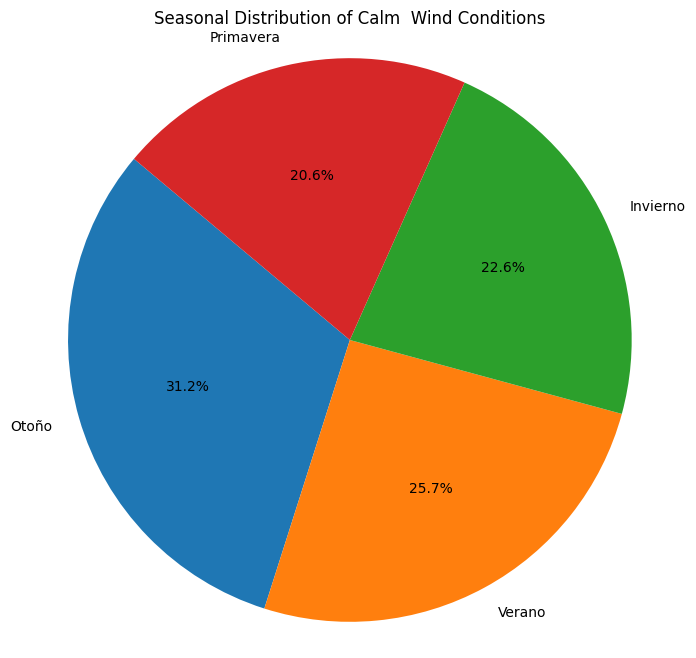

In [51]:
seasonal_cv_distribution = df_cv_wind['season'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 8))
plt.pie(seasonal_cv_distribution, labels=seasonal_cv_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Seasonal Distribution of Calm  Wind Conditions')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Aislamiento para eventos de precipitación

In [52]:
# Extract rows where 'snow' is 1 or 'rain' is 1
df_precipitation = df[(df['snow'] == 1) | (df['rain'] == 1)]
# Filter for snow events
df_snow_only = df_precipitation[df_precipitation['snow'] == 1]
# Filter for rain events
df_rain_only = df_precipitation[df_precipitation['rain'] == 1]

In [53]:
# Monthly snow events
monthly_snow_counts = df_snow_only['month'].value_counts().sort_index()
month_names_snow = [calendar.month_name[i] for i in monthly_snow_counts.index]
monthly_snow_counts.index = month_names_snow

print("\nNumber of snow events per month:")
print(monthly_snow_counts)

# Monthly rain events
monthly_rain_counts = df_rain_only['month'].value_counts().sort_index()
month_names_rain = [calendar.month_name[i] for i in monthly_rain_counts.index]
monthly_rain_counts.index = month_names_rain

print("\nNumber of rain events per month:")
print(monthly_rain_counts)

# Find month with most snow events
most_snow_month = monthly_snow_counts.idxmax()
max_snow_events = monthly_snow_counts.max()
print(f"\nMonth with the most snow events: {most_snow_month} ({max_snow_events} events)")

# Find month with most rain events
most_rain_month = monthly_rain_counts.idxmax()
max_rain_events = monthly_rain_counts.max()
print(f"Month with the most rain events: {most_rain_month} ({max_rain_events} events)")


Number of snow events per month:
January     111
February    121
March        59
November      3
December     74
Name: count, dtype: int64

Number of rain events per month:
January        5
February       4
March         70
April        122
May          177
June         258
July         369
August       234
September    279
October      139
November      78
December       4
Name: count, dtype: int64

Month with the most snow events: February (121 events)
Month with the most rain events: July (369 events)


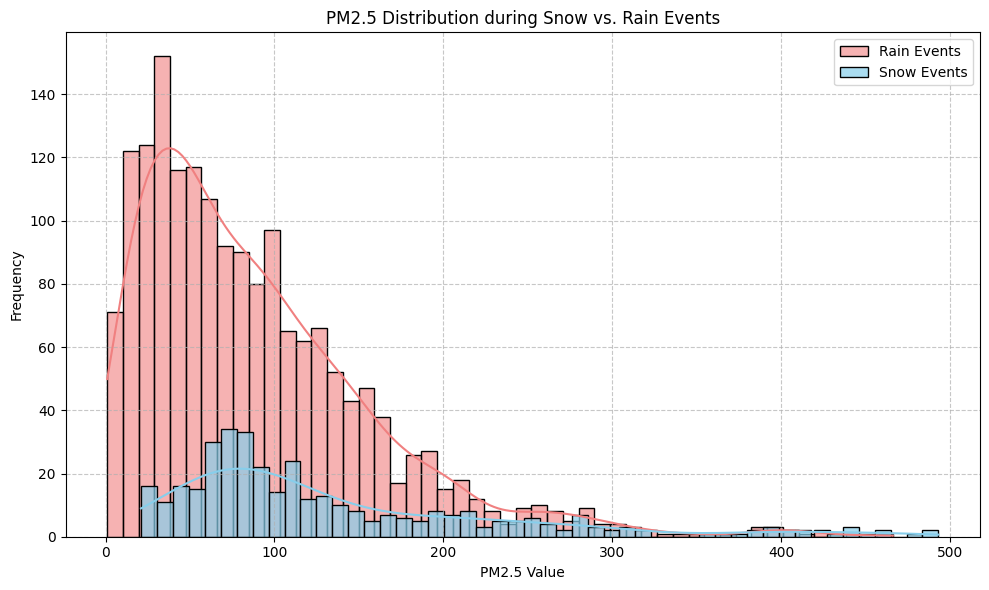

In [54]:
plt.figure(figsize=(10, 6))

# Plot PM2.5 distribution during Rain Events first (as a base)
sns.histplot(df_rain_only['pm2.5'].dropna(), bins=50, kde=True, color='lightcoral', edgecolor='black', label='Rain Events', alpha=0.6)

# Plot PM2.5 distribution during Snow Events on top for better visibility
sns.histplot(df_snow_only['pm2.5'].dropna(), bins=50, kde=True, color='skyblue', edgecolor='black', label='Snow Events', alpha=0.7)

plt.title('PM2.5 Distribution during Snow vs. Rain Events')
plt.xlabel('PM2.5 Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

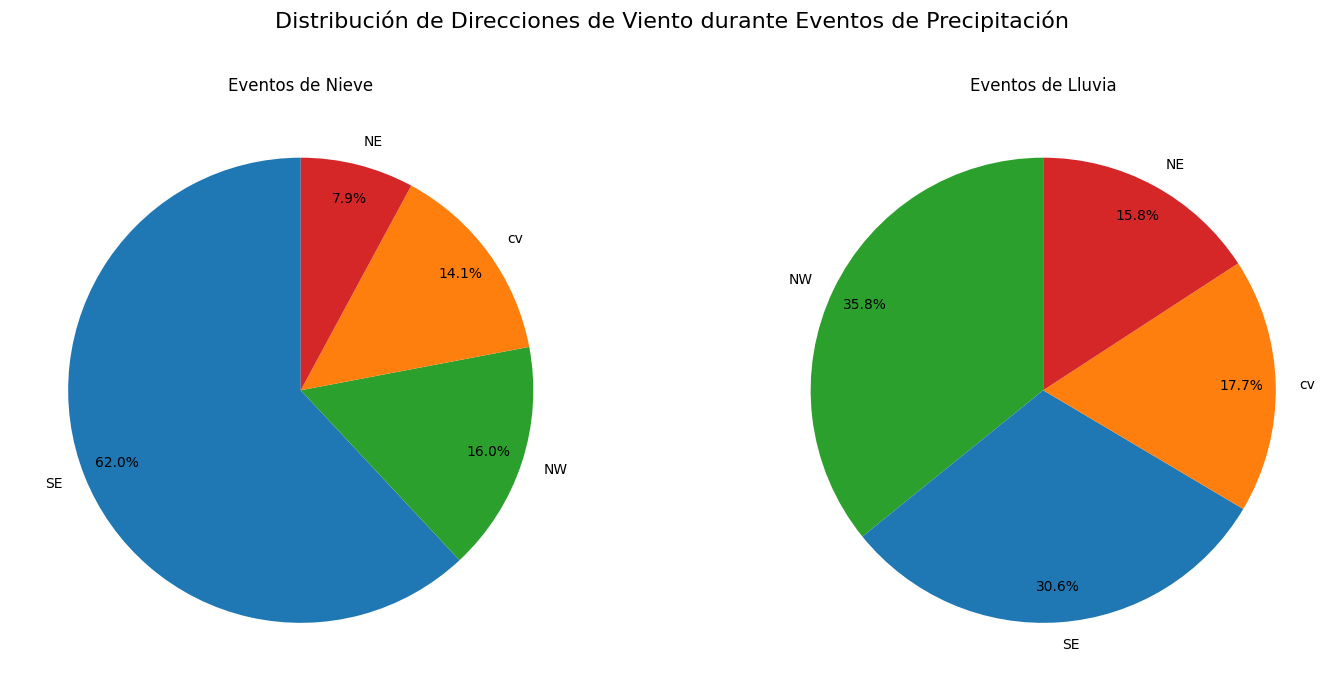

In [55]:
# Ensure df_snow_only and df_rain_only are clean of potential NaNs in 'cbwd'
df_snow_only_cleaned = df_snow_only.dropna(subset=['cbwd'])
df_rain_only_cleaned = df_rain_only.dropna(subset=['cbwd'])

# Get all unique wind directions from the combined precipitation data for consistent color mapping
all_unique_directions = pd.concat([df_snow_only_cleaned['cbwd'], df_rain_only_cleaned['cbwd']]).unique()

# Global color mapping for wind directions
cmap = plt.cm.tab10
colores_direcciones = {dir_viento: cmap(i) for i, dir_viento in enumerate(all_unique_directions)}

# Create subplots for snow and rain events
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('Distribución de Direcciones de Viento durante Eventos de Precipitación', fontsize=16)

# Plot for snow events
if not df_snow_only_cleaned.empty:
    datos_snow = df_snow_only_cleaned['cbwd'].value_counts(normalize=True) * 100
    colores_para_rebanadas_snow = [colores_direcciones[d] for d in datos_snow.index]
    wedges, texts, autotexts = axes[0].pie(datos_snow.values, labels=datos_snow.index, autopct='%1.1f%%',
                                           startangle=90, colors=colores_para_rebanadas_snow,
                                           pctdistance=0.85)
    axes[0].set_title('Eventos de Nieve')
    # Ensure text color is black for better readability
    for autotext in autotexts:
        autotext.set_color('black')
else:
    axes[0].text(0.5, 0.5, 'No hay datos de nieve para mostrar', horizontalalignment='center', verticalalignment='center', transform=axes[0].transAxes, fontsize=12)
    axes[0].set_title('Eventos de Nieve')

# Plot for rain events
if not df_rain_only_cleaned.empty:
    datos_rain = df_rain_only_cleaned['cbwd'].value_counts(normalize=True) * 100
    colores_para_rebanadas_rain = [colores_direcciones[d] for d in datos_rain.index]
    wedges, texts, autotexts = axes[1].pie(datos_rain.values, labels=datos_rain.index, autopct='%1.1f%%',
                                           startangle=90, colors=colores_para_rebanadas_rain,
                                           pctdistance=0.85)
    axes[1].set_title('Eventos de Lluvia')
    # Ensure text color is black for better readability
    for autotext in autotexts:
        autotext.set_color('black')
else:
    axes[1].text(0.5, 0.5, 'No hay datos de lluvia para mostrar', horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes, fontsize=12)
    axes[1].set_title('Eventos de Lluvia')

plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

Año 2013 (Airpocalipsis) vs. Otros años

In [56]:
df_pollution_events = df[df['pm_state'].isin([3.0])]
pollution_events_per_year = df_pollution_events['year'].value_counts().sort_index()
print("Number of high pollution events per year:")
display(pollution_events_per_year)

Number of high pollution events per year:


year
2010    4080
2011    3748
2012    4031
2013    4398
2014    4389
Name: count, dtype: int64

In [57]:
df_2013 = df[df['year'] == 2013]
df_other_years = df[df['year'] != 2013]

In [58]:
numerical_vars_to_compare = ['DEWP', 'TEMP', 'PRES', 'Iws', 'pm2.5']

print("Descriptive statistics for 2013:")
descriptive_stats_2013 = df_2013[numerical_vars_to_compare].describe()
display(descriptive_stats_2013)

print("\nDescriptive statistics for Other Years (excluding 2013):")
descriptive_stats_other_years = df_other_years[numerical_vars_to_compare].describe()
display(descriptive_stats_other_years)

Descriptive statistics for 2013:


DEWP         TEMP         PRES          Iws        pm2.5
count  8663.000000  8663.000000  8663.000000  8663.000000  8663.000000
mean      1.358190    12.415214  1015.804167    21.087981   100.542191
std      14.367692    12.019252    10.511058    47.634357    93.986821
min     -33.000000   -17.000000   991.000000     0.450000     2.000000
25%     -11.000000     2.000000  1007.000000     1.790000    32.000000
50%       0.000000    13.000000  1016.000000     4.920000    71.000000
75%      15.000000    23.000000  1024.000000    19.210000   137.000000
max      26.000000    38.000000  1046.000000   490.380000   603.000000


Descriptive statistics for Other Years (excluding 2013):


DEWP          TEMP          PRES           Iws         pm2.5
count  33068.000000  33068.000000  33068.000000  33068.000000  33068.000000
mean       1.861316     12.410971   1016.605011     24.610034     97.576600
std       14.451121     12.210853     10.239439     50.115249     89.533666
min      -40.000000    -19.000000    992.000000      0.450000      0.000000
25%      -10.000000      1.000000   1008.000000      1.790000     28.000000
50%        2.000000     14.000000   1016.000000      5.790000     73.000000
75%       15.000000     23.000000   1025.000000     22.800000    137.000000
max       28.000000     42.000000   1045.000000    565.490000    623.000000

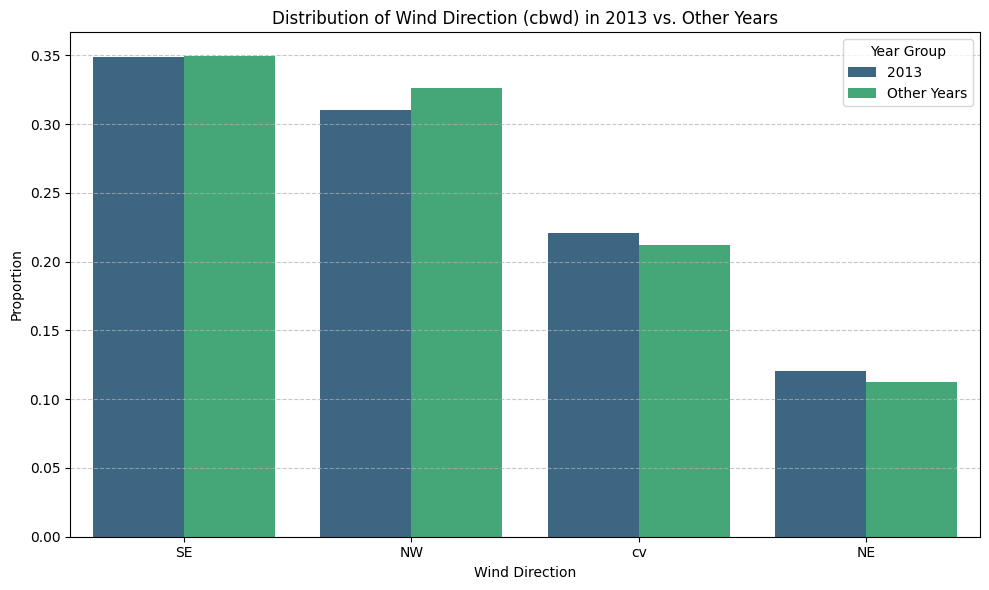

In [59]:
cbwd_2013_dist = df_2013['cbwd'].value_counts(normalize=True).reset_index()
cbwd_2013_dist.columns = ['cbwd', 'proportion']
cbwd_2013_dist['year_group'] = '2013'

cbwd_other_years_dist = df_other_years['cbwd'].value_counts(normalize=True).reset_index()
cbwd_other_years_dist.columns = ['cbwd', 'proportion']
cbwd_other_years_dist['year_group'] = 'Other Years'

cbwd_comparison = pd.concat([cbwd_2013_dist, cbwd_other_years_dist])

plt.figure(figsize=(10, 6))
sns.barplot(x='cbwd', y='proportion', hue='year_group', data=cbwd_comparison, palette='viridis')
plt.title('Distribution of Wind Direction (cbwd) in 2013 vs. Other Years')
plt.xlabel('Wind Direction')
plt.ylabel('Proportion')
plt.legend(title='Year Group')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

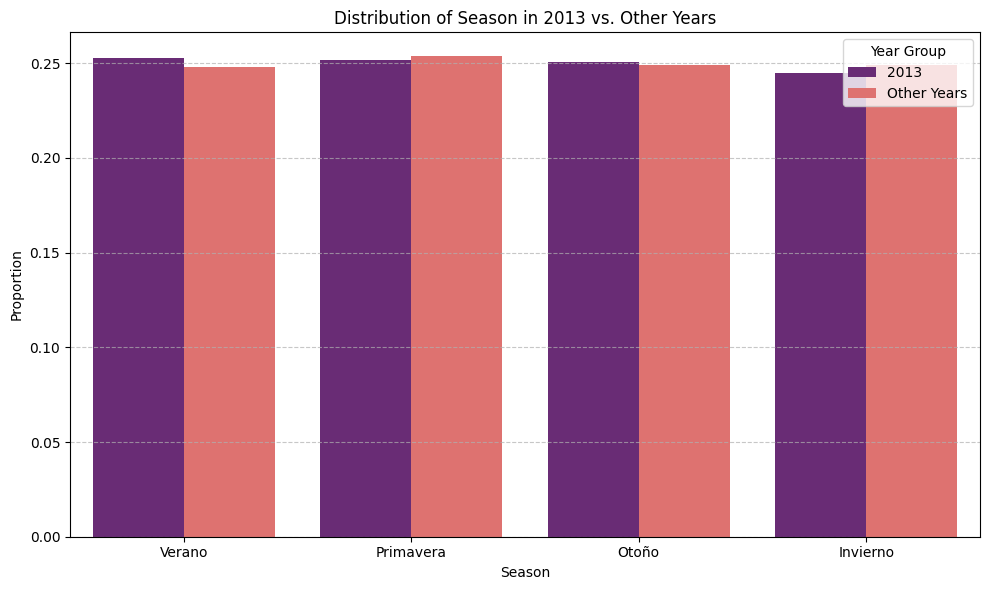

In [60]:
season_2013_dist = df_2013['season'].value_counts(normalize=True).reset_index()
season_2013_dist.columns = ['season', 'proportion']
season_2013_dist['year_group'] = '2013'

season_other_years_dist = df_other_years['season'].value_counts(normalize=True).reset_index()
season_other_years_dist.columns = ['season', 'proportion']
season_other_years_dist['year_group'] = 'Other Years'

season_comparison = pd.concat([season_2013_dist, season_other_years_dist])

plt.figure(figsize=(10, 6))
sns.barplot(x='season', y='proportion', hue='year_group', data=season_comparison, palette='magma')
plt.title('Distribution of Season in 2013 vs. Other Years')
plt.xlabel('Season')
plt.ylabel('Proportion')
plt.legend(title='Year Group')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()